Wyabstrachowane ze zbioru danych metodą PCA główne składowe zostaną poddane selekcji z wykorzystaniem algorytmu genetycznego. Zabieg ten ma na celu zoptymalizowanie procesu uczenia, m.in. poprzez dostarczanie jako dane wejściowe algorytmu uczenia maszynowego już gotowego zbioru cech, dzięki czemu możliwie efektywnie wykorzystując jego możliwości do identyfikowania zależności je charakteryzujących oraz estymowania rozwiązania problemu jaki opisują.  

**Random Decision Forest** - należy do metod zespołowych uczenia maszynowego, polega na konstruowaniu wielu drzew decyzyjnych w czasie uczenia i generowania klasy, która stanowi przewidywaną średnią poszczególnych drzew (regresja). W rozszerzonej wersji wykorzystuje m.in. agregację bootstrapa. Drzewa decyzyjne wykorzystuje się do eksploracji danych, selekcji cech naistotniejszych oraz odrzcaniu tych mniej ważnych, z racji dużych możliwości adaptacyjnych drzew, nawet dla nieregularnych wzorców, każde z drzew uczy się na inny fragmencie zbioru danych, a wynik uśrednia metodą Lasu losowego, co przekłada się na większą wydajność oraz mniejszą wariancję estymatorów.

Przygotowanie nieznędnych bibliotek :

In [1]:
# data manipulation tools
import pandas as pd
import numpy as np

# Random Forest model
from sklearn.ensemble import RandomForestRegressor

# Linear Regression model
from sklearn.linear_model import LinearRegression

# Epsilon-Support Vector Regression
from sklearn import svm 

# model selection
from sklearn.model_selection import cross_val_score # perform cross-validation for estimator evaluation
from sklearn.model_selection import cross_val_predict # generate cross-validated estimates for each input
from sklearn.model_selection import train_test_split # splits arrays/matrices into random train and test subsets
from sklearn.model_selection import GridSearchCV # determines estimator paremeters values
from sklearn.model_selection import StratifiedKFold # stratified k-fold cross-validator
from sklearn.model_selection import KFold # k-fold cross-validator

# feature selection based on weights importance
from sklearn.feature_selection import SelectFromModel

# data preprocessing
from sklearn.preprocessing import MinMaxScaler

# plots
import matplotlib.pyplot as plt

# rest
import random

### ETAP I : SELEKCJA CECH

Przygotowanie zbiorów zmiennych niezależnych oraz zależnych:

In [2]:
# dependent variables for regression - land av temps
%store -r data

dependent_vals = pd.DataFrame(data=data.loc[:, ['LandAverageTemperature']].values, columns=['LandAvTemps'])

In [3]:
dependent_vals.shape

(3192, 1)

In [4]:
dependent_vals.head()

,LandAvTemps
0,-0.515284
1,-0.510639
2,-0.269608
3,0.00184825
4,0.294062


In [5]:
# indepentent variables for regression
# primary components for min/max temps concatennated with measurements time intervals (days)
%store -r principalDf

days = []
for i in range(dependent_vals.size):
    # days with normalization (0-1)
    days.append(i/dependent_vals.size)

# days = pd.DataFrame(data=days, columns=['days'])
# independent_vals = principalDf.loc[:, ['princ_comp_1', 'princ_comp_2']].values
# independent_vals = pd.DataFrame(data=independent_vals, columns = ['princ_comp_1', 'princ_comp_2'])
# independent_vals = pd.concat([independent_vals, days], axis = 1)

days = pd.DataFrame(data=days, columns=['days'])
independent_vals = data.loc[:, ['LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty']].values
independent_vals = pd.DataFrame(data=independent_vals, columns = ['LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty'])
independent_vals = pd.concat([independent_vals, days], axis = 1)

In [6]:
independent_vals.shape

(3192, 5)

In [7]:
independent_vals.head()

,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,days
0,0.0960572,-0.798669,0.0779785,-0.775935,0.000000
1,0.0960572,-0.798669,0.0779785,-0.775935,0.000313
2,0.0960572,-0.798669,0.0779785,-0.775935,0.000627
3,0.0960572,-0.798669,0.0779785,-0.775935,0.000940
4,0.0960572,-0.798669,0.0779785,-0.775935,0.001253


Wydzielenie zbiorów treningowego (x, y) oraz testowego (x_test, y_test):

In [8]:
x, x_test, y, y_test = train_test_split(independent_vals, dependent_vals, test_size=0.1, random_state=0)

In [9]:
x.shape, y.shape

((2872, 5), (2872, 1))

In [10]:
x.head()

,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,days
779,0.0960572,-0.798669,0.0779785,-0.775935,0.244048
710,0.0960572,-0.798669,0.0779785,-0.775935,0.222431
983,0.0960572,-0.798669,0.0779785,-0.775935,0.307957
1961,0.70882,-0.849388,0.596879,-0.815233,0.614348
3019,0.871855,-0.972742,0.860997,-0.922966,0.945802


In [11]:
y.head()

,LandAvTemps
779,-0.250367
710,-0.478224
983,-0.588171
1961,0.42979
3019,0.56457


In [12]:
x_test.shape, y_test.shape

((320, 5), (320, 1))

In [13]:
x_test.head()

,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,days
936,0.0960572,-0.798669,0.0779785,-0.775935,0.293233
1732,0.43048,-0.816586,0.324957,-0.800174,0.542607
461,0.0960572,-0.798669,0.0779785,-0.775935,0.144424
480,0.0960572,-0.798669,0.0779785,-0.775935,0.150376
298,0.0960572,-0.798669,0.0779785,-0.775935,0.093358


In [14]:
y_test.head()

,LandAvTemps
936,-0.746458
1732,0.234444
461,0.5059
480,-0.571205
298,-0.515758


In [15]:
# Perform Grid-Search to find hyperparameters for regression estimator
# max_depth refers to tree depth
# n_estimators refers to number of threes in forest
# cv parameter determines number of folds of providet dataset or cross-validator object
gsc_rfr = GridSearchCV(estimator=RandomForestRegressor(), 
                   param_grid={'max_depth': range(2, 10), 'n_estimators': (10, 50, 100, 1000), },
                   cv=KFold(n_splits=10, shuffle=True, random_state=None), scoring='neg_mean_squared_error', 
                   verbose=1, n_jobs=-1, refit=True, return_train_score=True)

# fitting GridSearchCV instance with data to determine best parameters
grid_result = gsc_rfr.fit(x.values, y.values.ravel())
best_params = grid_result.best_params_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   41.4s finished


In [16]:
# best parameters privided by GridSearchCV
best_params

{'max_depth': 9, 'n_estimators': 1000}

In [17]:
# Random Forest Regressor estimator
rfr_estimator = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], 
                            random_state=False, verbose=0)

In [18]:
# Meta-transformer for selecting features based on importance weights
selection = SelectFromModel(rfr_estimator)

In [19]:
# fitting transformer
selection.fit(x.values, y.values.ravel())
pass

Sprawdzenie istotności cech zbioru treningowego (x), True jeśli kolumna ma większą ważność od średniej, False jeśli mniejszą

In [20]:
selection.get_support()

array([ True, False,  True, False, False])

Dokładne określenie istotności poszczególnych kolumn:

In [21]:
importance = selection.estimator_.feature_importances_
importance

array([0.34257683, 0.00074222, 0.59147932, 0.0005972 , 0.06460443])

Obliczenie liczby cech istotnych zbioru (x):

In [22]:
selected_features = x.columns[(selection.get_support())]
len(selected_features)

2

Wypisanie najistotniejszych cech:

In [23]:
print(selected_features)

Index(['LandMaxTemperature', 'LandMinTemperature'], dtype='object')


Rozkład wyselekcjonowanych cech:

In [24]:
# pd.Series(selection.estimator_.feature_importances_.ravel()).hist()

 1) LandMinTemperature             0.591479
 2) LandMaxTemperature             0.342577
 3) days                           0.064604
 4) LandMaxTemperatureUncertainty  0.000742
 5) LandMinTemperatureUncertainty  0.000597


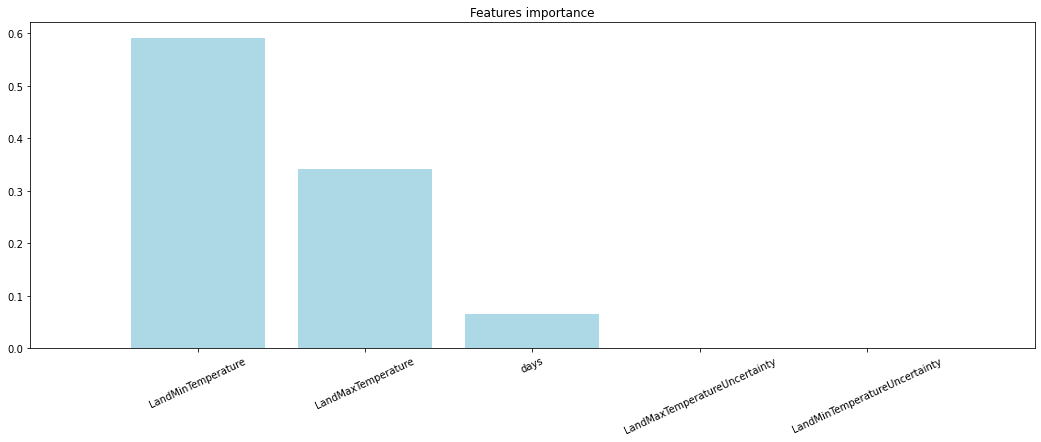

In [25]:
indices = np.argsort(importance)[::-1]
feat_labels = x.columns[:]
for f in range(x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indices[f]],
                           importance[indices[f]]))

plt.figure(figsize=(18,6))
plt.title('Features importance')
plt.bar(range(x.shape[1]),
       importance[indices],
       color='lightblue',
       align='center')

plt.xticks(range(x.shape[1]),
         feat_labels[indices], rotation=25)
plt.xlim([-1, x.shape[1]])
plt.tight_layout
plt.show()

Wyodrębnienie istotnych cech oraz odrzucenie pozostałych :

In [26]:
# slicing out not important features from train dataset
features = np.concatenate((np.array(selected_features), np.array(pd.Index(['days']), dtype='object')))
x_train = pd.DataFrame(data=x.loc[:, features])
x_test = pd.DataFrame(data=x_test.loc[:, features])
y_train = y

In [27]:
x_train.shape, y_train.shape

((2872, 3), (2872, 1))

In [28]:
x_train.head()

,LandMaxTemperature,LandMinTemperature,days
779,0.0960572,0.0779785,0.244048
710,0.0960572,0.0779785,0.222431
983,0.0960572,0.0779785,0.307957
1961,0.70882,0.596879,0.614348
3019,0.871855,0.860997,0.945802


In [29]:
y_train.head()

,LandAvTemps
779,-0.250367
710,-0.478224
983,-0.588171
1961,0.42979
3019,0.56457


### ETAP II : PREDYCJA Z WYKORZYSTANIEM MODELI REGRESJI LINIOWEJ

Szacowanie szukanej wartości średnich temperatur lądu dla wyselekcjonowanych danch z wykorzystaniem modeli regresji statystycznej opartych na konceptach RandomForestRegressor oraz SVM.

**Random Forest Regressor & GridSearchCV**

**TRENING**  
Ponowne dostosowanie modelu GridSearchCV do danych z nowo-wyselekcjonowanymi cechami:

In [30]:
# refitting GridSearchCV instance with selected data
gsc_rfr.fit(x_train.values, y_train.values.ravel())
pass

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   32.9s finished


In [31]:
# GridSearchCV trainig raport 
pd.DataFrame(data=gsc_rfr.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.023436,0.007815,0.000000,0.000000,2,10,"{'max_depth': 2, 'n_estimators': 10}",-0.079568,-0.074747,-0.086226,...,-0.073213,-0.073835,-0.074943,-0.075691,-0.074436,-0.074489,-0.073650,-0.075243,-0.074258,0.000842
1,0.126554,0.010938,0.003126,0.006251,2,50,"{'max_depth': 2, 'n_estimators': 50}",-0.079988,-0.074862,-0.086036,...,-0.073100,-0.073550,-0.074881,-0.075610,-0.074250,-0.074208,-0.073484,-0.074911,-0.074152,0.000759
2,0.257018,0.012262,0.007813,0.007813,2,100,"{'max_depth': 2, 'n_estimators': 100}",-0.080150,-0.074857,-0.085944,...,-0.072966,-0.073493,-0.074771,-0.075623,-0.074252,-0.074131,-0.073513,-0.074872,-0.074105,0.000762
3,2.499815,0.022398,0.085935,0.007813,2,1000,"{'max_depth': 2, 'n_estimators': 1000}",-0.080050,-0.074772,-0.085955,...,-0.072963,-0.073294,-0.074835,-0.075554,-0.074222,-0.074065,-0.073562,-0.075096,-0.074102,0.000798
4,0.031250,0.000002,0.001563,0.004688,3,10,"{'max_depth': 3, 'n_estimators': 10}",-0.077614,-0.072756,-0.083324,...,-0.069802,-0.070183,-0.071786,-0.072655,-0.071352,-0.071165,-0.070432,-0.072161,-0.071059,0.000878


**TEST**  
Evaluacja modelu na wcześniej wydzielonych danych testowych:

In [32]:
# mean negative MAE for the whole test set (no k-fold cross-validation performed)
gsc_rfr.score(x_test.values, y_test.values.ravel())

-0.06529284387078749

Model Predictions:

In [33]:
pd.DataFrame(data=gsc_rfr.predict(x_test.values), columns=['predictions']).head()

,predictions
0,-0.053703
1,0.226826
2,-0.017566
3,-0.031830
4,-0.008772


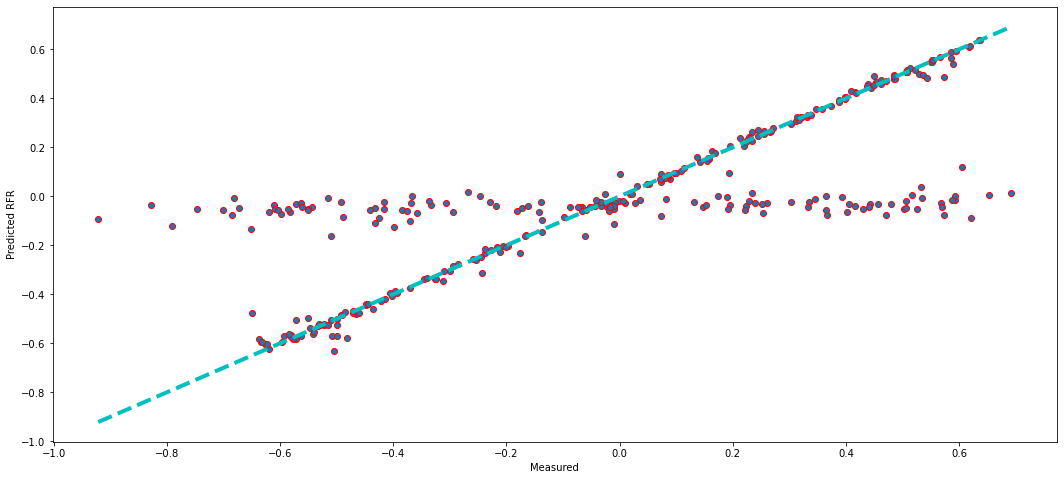

In [34]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(y_test, gsc_rfr.predict(x_test.values), edgecolors='r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='c')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted RFR')
plt.show()

**Support Vector Machine & GridSearchCV**

Utworzenie instancji GridSearchCV dla modelu SVM oraz optymalizacja hiperparametrów.

In [35]:
# Perform Grid-Search to find hyperparameters for SVM regression estimator
gsc_svm = GridSearchCV(estimator=svm.SVR(), 
                   param_grid={'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
                               'kernel': ['rbf', 'poly', 'sigmoid'], 'epsilon': [0.1,0.15,0.2,0.25,0.3],
                              'max_iter': [100, 1000, 10000, 100000, 1000000]},
                       cv=KFold(n_splits=10, shuffle=True, random_state=None), scoring='neg_mean_squared_error', 
                       verbose=1, n_jobs=-1, refit=True, return_train_score=True)

**TRENING**

In [36]:
# fitting GridSearchCV instance for SVM with selected data
grid_result = gsc_svm.fit(x_train.values, y_train.values.ravel())

Fitting 10 folds for each of 1200 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7212 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 10516 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:  3.6min finished


In [37]:
# GridSearchCV trainig raport 
pd.DataFrame(data=gsc_rnr.cv_results_).head()

NameError: name 'gsc_rnr' is not defined

**TEST**

In [ ]:
# mean negative MAE for the whole test set (no k-fold cross-validation performed)
gsc_svm.score(x_test.values, y_test.values.ravel())

In [ ]:
pd.DataFrame(data=gsc_svm.predict(x_test.values), columns=['predictions']).head()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(y_test, gsc_svm.predict(x_test), edgecolors='r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='c')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted SVM')
plt.show()

### ETAP III : Analiza uzyskanych wyników:

Prezentacja graficzna uzyskanych wyników:

In [ ]:
import seaborn as sns

Zestawienie predykcji z wartościami oczekiwanymi dla RNR:

In [ ]:
sns.pairplot(pd.concat([y_test, 
                        pd.DataFrame(data=gsc_rnr.predict(x_test), columns=['predictions_rnr'])],
                       axis = 1), palette='Dark2')

Zestawienie predykcji z wartościami oczekiwanymi dla SVM:

In [ ]:
sns.pairplot(pd.concat([y_test, 
                        pd.DataFrame(data=gsc_svm.predict(x_test), columns=['predictions_svm'])],
                       axis = 1), palette='Dark2')

Przedstawienie zależności między wartościami zmiennych niezależnych zbioru testowego (x_test), a wartościami uzyskanych  predykcji dla RNR :

In [ ]:
sns.pairplot(pd.concat([x_test, 
                        pd.DataFrame(data=gsc_rnr.predict(x_test), columns=['predictions_rnr'])],
                       axis = 1), palette='Dark2')

Przedstawienie zależności między wartościami zmiennych niezależnych zbioru testowego (x_test), a wartościami uzyskanych predykcji dla SVM :

In [ ]:
sns.pairplot(pd.concat([x_test, 
                        pd.DataFrame(data=gsc_svm.predict(x_test), columns=['predictions_svm'])],
                       axis = 1), palette='Dark2')

Przedstawienie zależności między wartościami zmiennych niezależnych zbioru testowego (x_test), a wartościami oczekiwanymi zmiennej niezależnej (y_test):

In [ ]:
sns.pairplot(pd.concat([x_test, y_test], axis = 1), palette='Dark2')